In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scgen
from matplotlib import pyplot as plt
import os

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/scanpygpu/

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Load the Dataset

In [5]:
SCRNA_DIR = '../data/scRNA/'

In [6]:
%time scrna = sc.read_h5ad(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 388 ms, sys: 176 ms, total: 564 ms
Wall time: 565 ms


In [7]:
scrna

AnnData object with n_obs × n_vars = 53638 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Group_colors', 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'

In [8]:
network = scgen.VAEArithKeras(scrna.shape[1], z_dimension=10, model_path='./models/scrna')

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 3000)              0         
_________________________________________________________________
encoder (Model)              (None, 10)                3062420   
_________________________________________________________________
decoder (Model)              (None, 3000)              3057400   
Total params: 6,119,820
Trainable params: 6,113,420
Non-trainable params: 6,400
_________________________________________________________________


In [9]:
history = network.train(scrna, n_epochs=100, verbose=1)


Epoch 1/100
53638/53638 [==============================] - 26s 476us/step - loss: 168.9526 - kl_loss: 382.3678 - recon_loss: 168.9335
Epoch 2/100
53638/53638 [==============================] - 25s 472us/step - loss: 146.2815 - kl_loss: 483.8518 - recon_loss: 146.2572
Epoch 3/100
53638/53638 [==============================] - 25s 468us/step - loss: 142.2616 - kl_loss: 556.4561 - recon_loss: 142.2339
Epoch 4/100
53638/53638 [==============================] - 25s 470us/step - loss: 140.5510 - kl_loss: 627.9061 - recon_loss: 140.5195
Epoch 5/100
53638/53638 [==============================] - 25s 459us/step - loss: 139.4863 - kl_loss: 691.5420 - recon_loss: 139.4517
Epoch 6/100
53638/53638 [==============================] - 25s 460us/step - loss: 138.8359 - kl_loss: 742.4384 - recon_loss: 138.7988
Epoch 7/100
53638/53638 [==============================] - 25s 463us/step - loss: 138.2888 - kl_loss: 782.9598 - recon_loss: 138.2496
Epoch 8/100
53638/53638 [==============================] - 25

# Analysis

In [10]:
adata = scrna

### UMAP of the latent space

In [11]:
adata_latent = network.to_latent(adata.X)
adata_latent = sc.AnnData(adata_latent)
adata_latent.obs = adata.obs

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anac

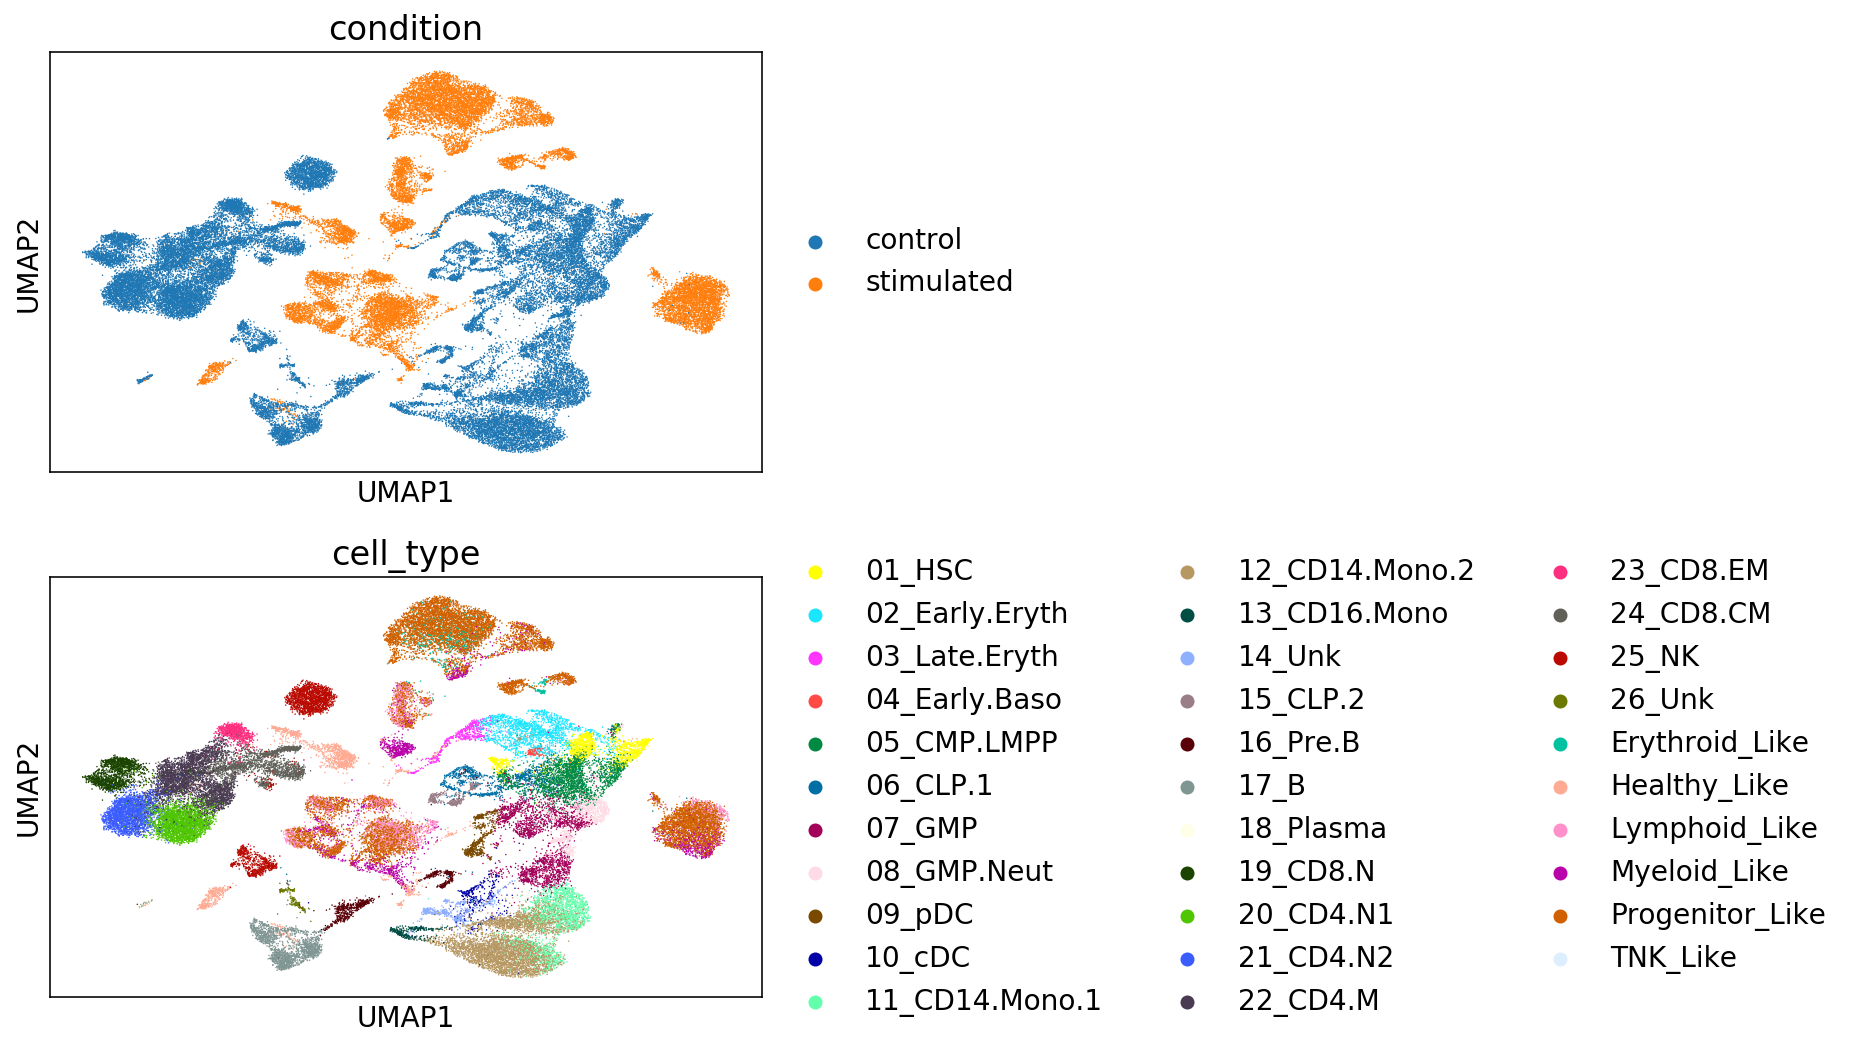

In [12]:
sc.pp.neighbors(adata_latent, random_state=42)
sc.tl.umap(adata_latent, random_state=42)
sc.pl.umap(adata_latent, color=['condition', 'cell_type'], ncols=1)

### Predict control data using arithmetic mean

In [13]:
pred, delta = network.predict(adata=adata, adata_to_predict=adata[adata.obs['condition'] == 'control'],
                           conditions={'ctrl': 'control', 'stim': 'stimulated'},
                           cell_type_key="cell_type", condition_key="condition")
delta

array([-5.2431154, 11.380264 ,  1.603117 ,  5.294162 , -2.239626 ,
       -5.4271836,  5.184346 ,  1.7795767,  5.9763064, -2.048888 ],
      dtype=float32)

In [14]:
pred_adata = sc.AnnData(pred,
                        obs=adata.obs[adata.obs['condition'] == 'control'],
                        var=adata.var)
pred_adata.obs['condition'] = 'predicted'
pred_adata

AnnData object with n_obs × n_vars = 35582 × 3000 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition'
    var: 'gene_name', 'gene_id', 'exonLength', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [15]:
all_adata = adata.concatenate(pred_adata)
all_adata

AnnData object with n_obs × n_vars = 89220 × 3000 
    obs: 'Barcode', 'Group', 'batch', 'cell_type', 'condition', 'nGene', 'nUMI', 'nUMI_pre'
    var: 'gene_name-0', 'gene_id-0', 'exonLength-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_name-1', 'gene_id-1', 'exonLength-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/scanpygpu/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

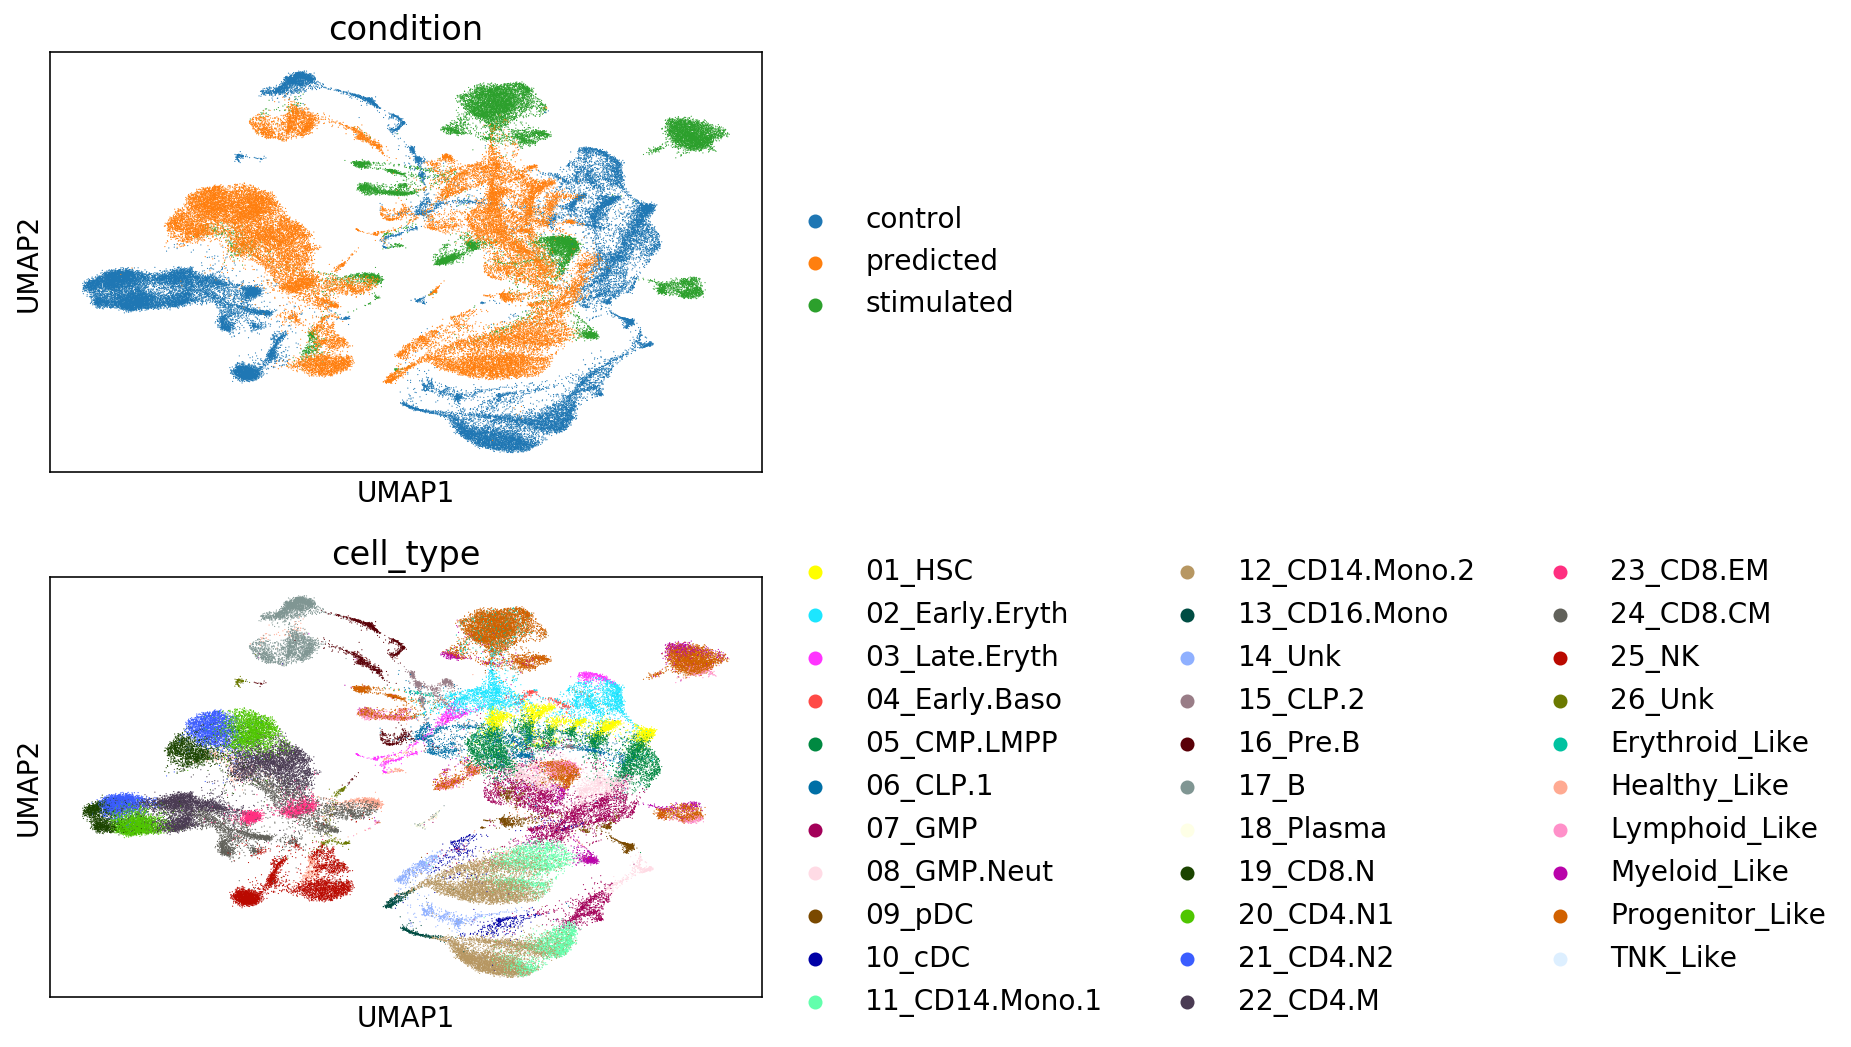

In [16]:
sc.pp.neighbors(all_adata, random_state=42)
sc.tl.umap(all_adata, random_state=42)
sc.pl.umap(all_adata, color=['condition', 'cell_type'], ncols=1)

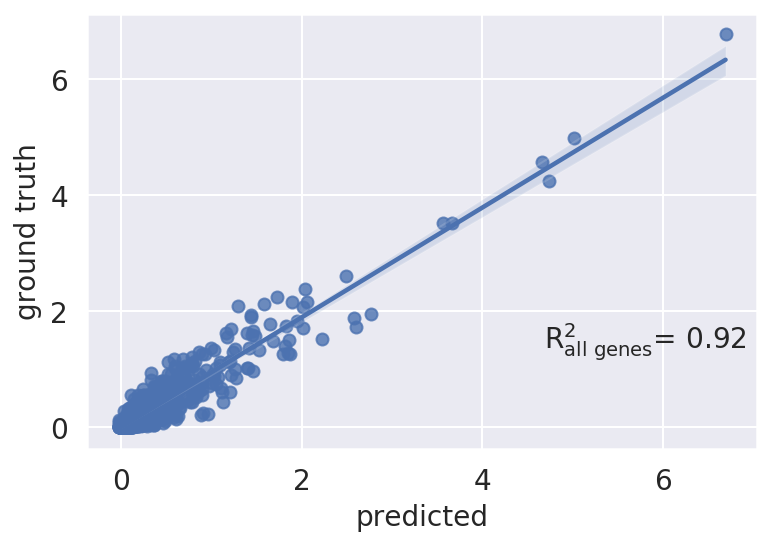

In [17]:
r2_value = scgen.plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={"x": "predicted", "y": "stimulated"},
                                        labels={"x": "predicted", "y": "ground truth"},
                                        show=True,
                                        legend=False)

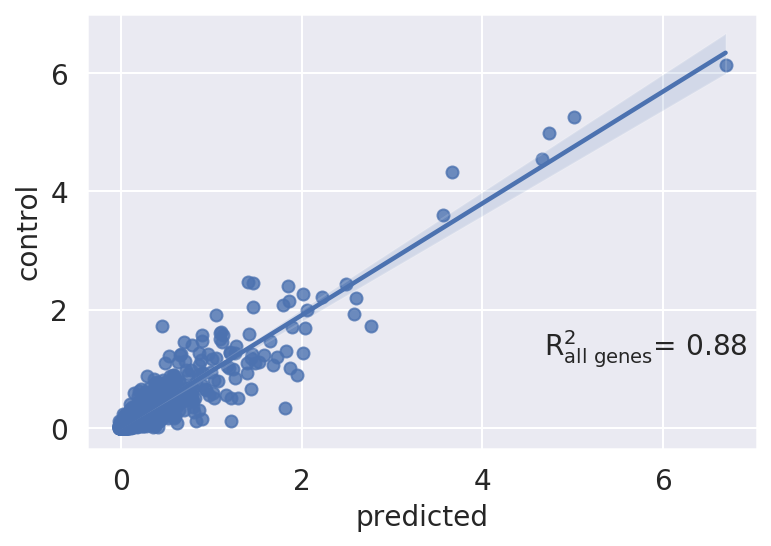

In [18]:
r2_value = scgen.plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={"x": "predicted", "y": "control"},
                                        labels={"x": "predicted", "y": "control"},
                                        show=True,
                                        legend=False)

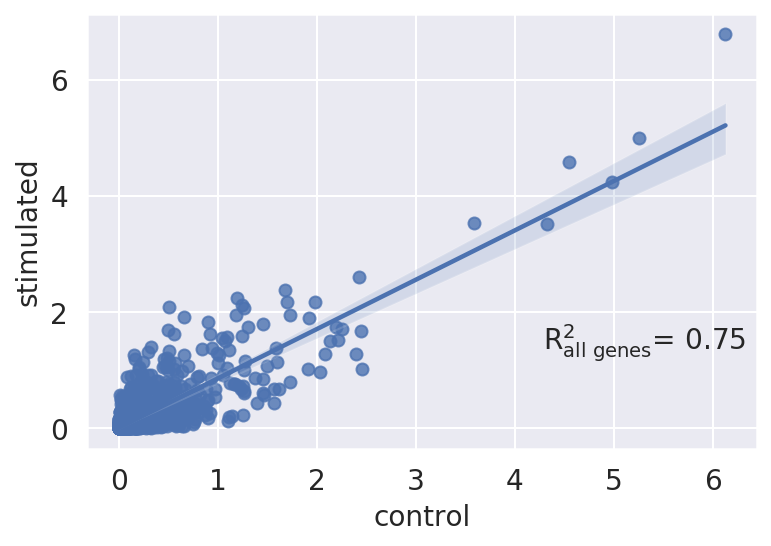

In [19]:
r2_value = scgen.plotting.reg_mean_plot(all_adata, condition_key="condition",
                                        axis_keys={"x": "control", "y": "stimulated"},
                                        labels={"x": "control", "y": "stimulated"},
                                        show=True,
                                        legend=False)